In [ ]:
import cv2
import numpy as np

MARGIN = 10
ROW_SIZE = 10
FONT_SIZE = 1
FONT_THICKNESS = 1
TEXT_COLOR = (255, 0, 0)  # red


def visualize(
    image,
    detection_result
) -> np.ndarray:
  """Draws bounding boxes on the input image and return it.
  Args:
    image: The input RGB image.
    detection_result: The list of all "Detection" entities to be visualize.
  Returns:
    Image with bounding boxes.
  """
  for detection in detection_result.detections:
    # Draw bounding_box
    bbox = detection.bounding_box
    start_point = bbox.origin_x, bbox.origin_y
    end_point = bbox.origin_x + bbox.width, bbox.origin_y + bbox.height
    cv2.rectangle(image, start_point, end_point, TEXT_COLOR, 3)

    # Draw label and score
    category = detection.categories[0]
    category_name = category.category_name
    probability = round(category.score, 2)
    result_text = category_name + ' (' + str(probability) + ')'
    text_location = (MARGIN + bbox.origin_x,
                     MARGIN + ROW_SIZE + bbox.origin_y)
    cv2.putText(image, result_text, text_location, cv2.FONT_HERSHEY_PLAIN,
                FONT_SIZE, TEXT_COLOR, FONT_THICKNESS)

  return image

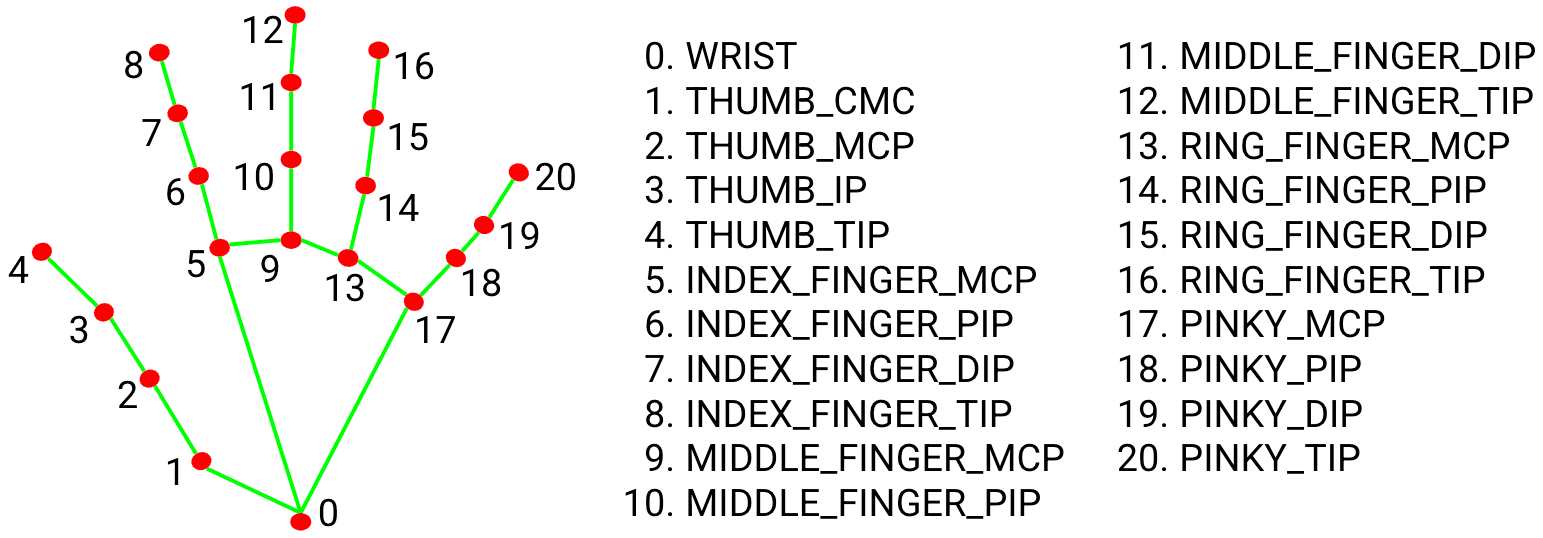

In [ ]:
# COLLECTS DATA FROM CAMERA FOR TRAINING

import cv2
import mediapipe as mp
import math
import csv
import os

INPUT_GESTURE_NAME = "Peace"
gesture_number = 0

cap = cv2.VideoCapture(0)
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

# CSV file to store gestures
csv_file = 'gestures.csv'
FIXED_DISTANCE = 10  # Define the fixed distance between node 0 and node 9

# Create the CSV file if it doesn't exist and add the header
if not os.path.exists(csv_file):
    with open(csv_file, mode='w', newline='') as f:
        writer = csv.writer(f)
        header = ['Gesture']
        for i in range(21):
            header += [f'Node_{i}_X'] + [f'Node_{i}_Y']
        writer.writerow(header)

# Function to calculate the angle of a line between two points
def calculate_angle(p1, p2):
    delta_x = p2[0] - p1[0]
    delta_y = p2[1] - p1[1]
    return math.atan2(delta_y, delta_x)

# Function to normalize points based on a fixed distance between node 0 and node 9
def normalize_to_fixed_distance(points, node_0, node_9, fixed_distance):
    current_distance = math.sqrt((node_9[0] - node_0[0])**2 + (node_9[1] - node_0[1])**2)
    scale_factor = fixed_distance / current_distance if current_distance != 0 else 1
    normalized_points = [(x * scale_factor, y * scale_factor) for x, y in points]
    return normalized_points

# Function to rotate points around the origin by a given angle
def rotate_point(point, angle_rad):
    x, y = point
    cos_theta = math.cos(angle_rad)
    sin_theta = math.sin(angle_rad)
    x_rotated = x * cos_theta - y * sin_theta
    y_rotated = x * sin_theta + y * cos_theta
    return (x_rotated, y_rotated)

# Function to generate mirrored points along the vertical axis
def mirror_points(points):
    mirrored_points = [(-x, y) for x, y in points]
    return mirrored_points

# Save gesture data to the CSV file
def save_gesture_to_csv(gesture_name, positions):
    with open(csv_file, mode='a', newline='') as f:
        writer = csv.writer(f)
        row = [gesture_name] + [coord for pos in positions for coord in pos]
        writer.writerow(row)

with mp_hands.Hands(min_detection_confidence=0.8, min_tracking_confidence=0.5) as hands:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame = cv2.flip(frame, 1)

        # Convert to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        # Process hand landmarks
        results = hands.process(image)

        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                # Get the position of node 0 and 9
                wrist = hand_landmarks.landmark[0]
                node_9 = hand_landmarks.landmark[9]

                # Get screen coordinates of wrist (node 0) and node 9
                wrist_pos = (wrist.x, wrist.y)
                node_9_pos = (node_9.x, node_9.y)

                # Calculate the angle to rotate the hand so node 9 is directly above node 0
                angle = calculate_angle(wrist_pos, node_9_pos)

                # Rotate to make the line vertical
                rotate_angle = math.pi / 2 + angle

                # Collect rotated positions
                rotated_positions = []
                for landmark in hand_landmarks.landmark:
                    # Relative position to landmark 0
                    relative_x = landmark.x - wrist.x
                    relative_y = landmark.y - wrist.y
                    # Rotate the point
                    rotated_x, rotated_y = rotate_point((relative_x, relative_y), rotate_angle)
                    rotated_positions.append((rotated_x, rotated_y))

                # Normalize positions to ensure the distance between node 0 and 9 is fixed
                normalized_positions = normalize_to_fixed_distance(
                    rotated_positions, 
                    rotated_positions[0], 
                    rotated_positions[9], 
                    FIXED_DISTANCE
                )

                # Generate mirrored version
                mirrored_positions = mirror_points(normalized_positions)

                # Visualize the landmarks (original normalized positions)
                for idx, (normalized_x, normalized_y) in enumerate(normalized_positions):
                    cx = int((normalized_x + wrist.x) * frame.shape[1])
                    cy = int((normalized_y + wrist.y) * frame.shape[0])
                    cv2.circle(image, (cx, cy), 5, (0, 255, 0), cv2.FILLED)

                key = cv2.waitKey(5) & 0xFF
                if key == ord('r'):
                    INPUT_GESTURE_NAME = input("Enter new gesture to record")
                if key == ord('j'):  # Press 'j' to save the gesture
                    # Prompt for gesture name
                    if INPUT_GESTURE_NAME != '':
                        gesture_name = INPUT_GESTURE_NAME
                    else:
                        gesture_name = input("Enter the gesture name: ")
                    gesture_number += 1
                    print(f"Saving gesture #{gesture_number}: {gesture_name}")
                    save_gesture_to_csv(gesture_name, normalized_positions)
                    save_gesture_to_csv(gesture_name, mirrored_positions)  # Save mirrored

                    # Display a confirmation message on the screen
                    confirmation_text = f"Gesture '{gesture_name}' saved!"
                    cv2.putText(
                        image, confirmation_text, 
                        (10, 30),  # Position (top-left corner)
                        cv2.FONT_HERSHEY_SIMPLEX,  # Font
                        1,  # Font scale
                        (0, 255, 0),  # Text color (green)
                        2,  # Thickness
                        cv2.LINE_AA  # Line type
                    )
                    # Optionally, display the confirmation for a few frames
                    for _ in range(20):  # Adjust as needed to show the message longer
                        cv2.imshow('Hand Tracking', image)
                        cv2.waitKey(50)  # Delay to keep showing the text

        # Display the result
        cv2.imshow('Hand Tracking', image)

        # Quit the program if 'q' is pressed
        key = cv2.waitKey(10) & 0xFF
        if key == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()


Best parameters: {'metric': 'chebyshev', 'n_neighbors': 2}
Model saved as knn_model.pkl


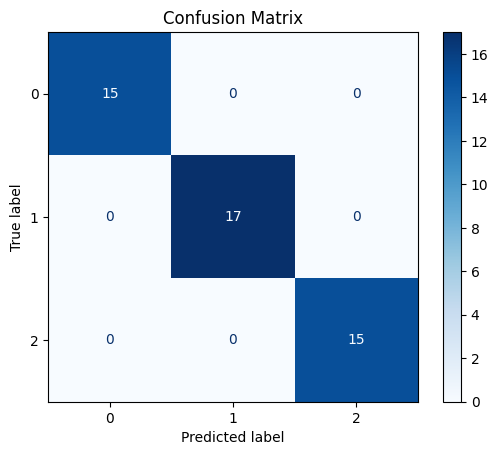

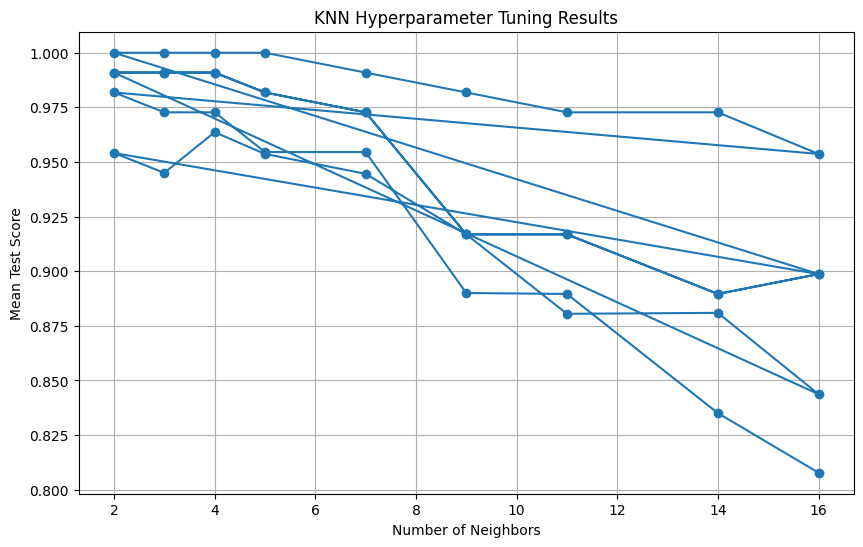


Tuned Accuracy of KNN model: 1.00


In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib

# Load CSV file
def load_csv(file_path):
    data = pd.read_csv(file_path)
    return data

# Preprocess the data
def preprocess_data(data):
    # Convert gesture names to numeric labels
    labels = data['Gesture'].astype('category').cat.codes  # Convert gesture names to numeric codes

    # Get Node values as features (drop Gesture column)
    features = data.drop('Gesture', axis=1).astype(float)

    return features, labels

# Train model
def train_knn_with_tuning(features, labels, save_model=False, model_filename='knn_model.pkl'):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

    # Set up hyperparameters grid for tuning
    param_grid = {
        'n_neighbors': [2, 3, 4, 5, 7, 9, 11, 14, 16],
        'metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev', 'cosine']
    }

    # Initialize KNN Classifier and GridSearchCV
    knn = KNeighborsClassifier()
    grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

    # Fit the model using GridSearch
    grid_search.fit(X_train, y_train)

    # Print best parameters
    print(f"Best parameters: {grid_search.best_params_}")
    best_knn = grid_search.best_estimator_

    # Save the model if specified
    if save_model:
        joblib.dump(best_knn, model_filename)
        print(f"Model saved as {model_filename}")

    # Predict the testing data
    y_pred = best_knn.predict(X_test)

    # Determine the accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=best_knn.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_knn.classes_)
    
    # Display confusion matrix
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

    # Plot the accuracy
    results = pd.DataFrame(grid_search.cv_results_)
    plt.figure(figsize=(10, 6))
    plt.plot(results['param_n_neighbors'], results['mean_test_score'], marker='o')
    plt.xlabel('Number of Neighbors')
    plt.ylabel('Mean Test Score')
    plt.title('KNN Hyperparameter Tuning Results')
    plt.grid()
    plt.show()

    return accuracy

# Path to the gestures CSV file
file_path = 'gestures.csv'

# Load and preprocess data
data = load_csv(file_path)
features, labels = preprocess_data(data)

# Train, evaluate, and save model
accuracy = train_knn_with_tuning(features, labels, save_model=True, model_filename='knn_model.pkl')

# Print the final tuned accuracy of the model
print(f"\nTuned Accuracy of KNN model: {accuracy:.2f}")


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt
import joblib

# Load CSV file
def load_csv(file_path):
    data = pd.read_csv(file_path)
    return data

# Preprocess the data
def preprocess_data(data):
    labels = data['Gesture']

    # Get Node values as features
    features = data.drop('Gesture', axis=1).astype(float)

    return features, labels

# Train model
def train_knn_with_tuning(features, labels, save_model=False, model_filename='knn_model_tuned.pkl'):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.6, random_state=42)

    # Set up hyperparameters grid for tuning
    param_grid = {
        'n_neighbors': [1, 2, 3, 4, 5, 7, 9, 11, 14, 16],
        'metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev', 'cosine']
    }

    # Initialize KNN Classifier and GridSearchCV
    knn = KNeighborsClassifier()
    grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

    # Fit the model using GridSearch
    grid_search.fit(X_train, y_train)

    # Print best parameters
    print(f"Best parameters: {grid_search.best_params_}")
    best_knn = grid_search.best_estimator_

    # Save the model
    if save_model:
        joblib.dump(best_knn, model_filename)
        print(f"Model saved as {model_filename}")

    # Evaluate the model for each metric
    metrics = param_grid['metric']
    accuracy_list, sensitivity_list, specificity_list = [], [], []

    for metric in metrics:
        # Train the model with the specified metric
        knn_metric = KNeighborsClassifier(n_neighbors=grid_search.best_params_['n_neighbors'], metric=metric)
        knn_metric.fit(X_train, y_train)
        
        # Predict the testing data
        y_pred = knn_metric.predict(X_test)

        # Generate confusion matrix
        cm = confusion_matrix(y_test, y_pred, labels=knn_metric.classes_)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_metric.classes_)

        # Display confusion matrix
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f'Confusion Matrix - Metric: {metric}')
        plt.show()

        # Calculate accuracy, sensitivity, and specificity
        accuracy = accuracy_score(y_test, y_pred)
        sensitivity = np.mean([cm[i, i] / np.sum(cm[i, :]) if np.sum(cm[i, :]) > 0 else 0 for i in range(len(cm))])
        specificity = np.mean([np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1)) /
                               np.sum(np.delete(cm, i, axis=0)) if np.sum(np.delete(cm, i, axis=0)) > 0 else 0
                               for i in range(len(cm))])

        # Append metrics for visualization
        accuracy_list.append(accuracy)
        sensitivity_list.append(sensitivity)
        specificity_list.append(specificity)

        # Print metrics
        print(f"Accuracy with metric '{metric}': {accuracy:.2f}")
        print(f"Sensitivity with metric '{metric}': {sensitivity:.2f}")
        print(f"Specificity with metric '{metric}': {specificity:.2f}")

    # Plot metrics
    plt.figure(figsize=(12, 6))
    x = np.arange(len(metrics))
    width = 0.25

    plt.bar(x - width, accuracy_list, width, label='Accuracy')
    plt.bar(x, sensitivity_list, width, label='Sensitivity')
    plt.bar(x + width, specificity_list, width, label='Specificity')

    plt.xlabel('Distance Metrics')
    plt.ylabel('Scores')
    plt.title('Performance Metrics by Distance Metric')
    plt.xticks(x, metrics, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Return the accuracy of the best model
    best_accuracy = accuracy_score(y_test, best_knn.predict(X_test))
    return best_accuracy

file_path = 'gestures.csv'

data = load_csv(file_path)

features, labels = preprocess_data(data)

# Train, evaluate, and save model
accuracy = train_knn_with_tuning(features, labels, save_model=True, model_filename='knn_model_tuned.pkl')

print(f"\nTuned Accuracy of KNN model: {accuracy:.2f}")


In [ ]:
import cv2
import mediapipe as mp
import math
import joblib  # To load the KNN model
import numpy as np

# Load the pre-trained KNN model
knn_model = joblib.load('knn_model.pkl')

# Gesture names corresponding to the numeric labels (adjust based on your training data)
gesture_names = [
    "Gesture 1",  # Replace with your actual gesture names
    "Gesture 2", 
    "Gesture 3",
    "Gesture 4",
    "Gesture 5",
    # Add more gestures here based on your dataset
]

# KNN gesture prediction function
def predict_gesture(gesture_data):
    # Convert gesture data to a format expected by the model
    gesture_array = np.array(gesture_data).flatten().reshape(1, -1)
    prediction = knn_model.predict(gesture_array)
    predicted_label = prediction[0]
    # Map numeric prediction to gesture name
    return gesture_names[predicted_label]

# Initialize the camera and Mediapipe Hands model
cap = cv2.VideoCapture(0)
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

FIXED_DISTANCE = 10  # Define the fixed distance between node 0 and node 9

# Function to calculate the angle of a line between two points
def calculate_angle(p1, p2):
    delta_x = p2[0] - p1[0]
    delta_y = p2[1] - p1[1]
    return math.atan2(delta_y, delta_x)

# Function to normalize points based on a fixed distance between node 0 and node 9
def normalize_to_fixed_distance(points, node_0, node_9, fixed_distance):
    current_distance = math.sqrt((node_9[0] - node_0[0])**2 + (node_9[1] - node_0[1])**2)
    scale_factor = fixed_distance / current_distance if current_distance != 0 else 1
    normalized_points = [(x * scale_factor, y * scale_factor) for x, y in points]
    return normalized_points

# Function to rotate points around the origin by a given angle
def rotate_point(point, angle_rad):
    x, y = point
    cos_theta = math.cos(angle_rad)
    sin_theta = math.sin(angle_rad)
    x_rotated = x * cos_theta - y * sin_theta
    y_rotated = x * sin_theta + y * cos_theta
    return (x_rotated, y_rotated)

with mp_hands.Hands(min_detection_confidence=0.8, min_tracking_confidence=0.5) as hands:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame = cv2.flip(frame, 1)

        # Convert to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        # Process hand landmarks
        results = hands.process(image)

        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                # Get the position of node 0 and 9
                wrist = hand_landmarks.landmark[0]
                node_9 = hand_landmarks.landmark[9]

                # Get screen coordinates of wrist (node 0) and node 9
                wrist_pos = (wrist.x, wrist.y)
                node_9_pos = (node_9.x, node_9.y)

                # Calculate the angle to rotate the hand so node 9 is directly above node 0
                angle = calculate_angle(wrist_pos, node_9_pos)

                # Rotate to make the line vertical
                rotate_angle = math.pi / 2 + angle

                # Collect rotated positions
                rotated_positions = []
                for landmark in hand_landmarks.landmark:
                    # Relative position to landmark 0
                    relative_x = landmark.x - wrist.x
                    relative_y = landmark.y - wrist.y
                    # Rotate the point
                    rotated_x, rotated_y = rotate_point((relative_x, relative_y), rotate_angle)
                    rotated_positions.append((rotated_x, rotated_y))

                # Normalize positions to ensure the distance between node 0 and 9 is fixed
                normalized_positions = normalize_to_fixed_distance(
                    rotated_positions, 
                    rotated_positions[0], 
                    rotated_positions[9], 
                    FIXED_DISTANCE
                )

                # Flatten the normalized positions for KNN model
                gesture_data = normalized_positions  # No mirroring applied

                # Predict the gesture using the KNN model
                predicted_gesture = predict_gesture(gesture_data)

                # Visualize the landmarks (original normalized positions)
                for idx, (normalized_x, normalized_y) in enumerate(normalized_positions):
                    cx = int((normalized_x + wrist.x) * frame.shape[1])
                    cy = int((normalized_y + wrist.y) * frame.shape[0])
                    cv2.circle(image, (cx, cy), 5, (0, 255, 0), cv2.FILLED)

                # Display the predicted gesture on the screen
                cv2.putText(image, f"Predicted Gesture: {predicted_gesture}", (10, 30), 
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

        # Display the result
        cv2.imshow('Hand Tracking', image)

        # Quit the program if 'q' is pressed
        key = cv2.waitKey(10) & 0xFF
        if key == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()


C:\Users\jjgei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
C:\Users\jjgei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\jjgei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.

KeyboardInterrupt: 